<a href="https://colab.research.google.com/github/magdamorim/INESCTEC/blob/main/Experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# imports
import numpy as np
from datasets import load_dataset
import torch
from datasets import load_dataset
from PIL import Image
from transformers import CLIPProcessor, CLIPModel,GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import numpy as np
import torch

In [94]:
# Load the Fashion MNIST dataset
dataset = load_dataset("fashion_mnist")

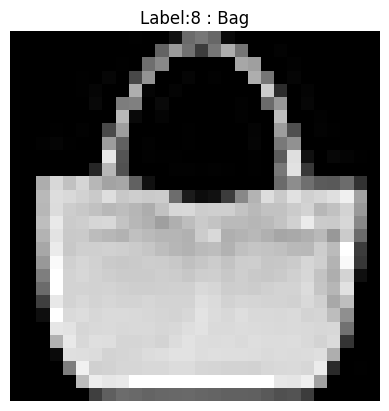

In [95]:
classes=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# Function to plot an image
def show_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f"Label:{label} : {classes[label]}")
    plt.axis('off')
    plt.show()

# Load an example image and label
example = dataset['train'][100]
image = example['image']
label = example['label']

# Display the image
show_image(image, label)


#### Download models pretrained

In [96]:


# Load the CLIP model with ViT-B-32. # CLIP
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# Initialize the ViT processor and model # IMAGE ENCODER
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model_image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")


# Load the GPT-2 model and tokenizer TEXT ENCODER
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # breaks text into tokens and gives qual attention
gpt_model = GPT2Model.from_pretrained("gpt2") # pretreained model



The tokenizer splits the text into tokens and gives an ID according to vocabulary. Example 32 means start sequence. Then it gives a constant attention mask that changes when applying the model to give attention to certain words.

### TEXT ENCODER

In [97]:
# Example text
text = "A stylish shirt for a casual look."
text=classes[label]


inputs = gpt_tokenizer(text, return_tensors="pt")

# Forward pass through the model
# disable the gradient because is zero shoot training so just run model without training
# it allows faster computation without gradient
with torch.no_grad():
    outputs = gpt_model(**inputs)

# Extract the features (hidden states)
# outputs have everything like attention scores, etc.
features = outputs.last_hidden_state


In [98]:
inputs["attention_mask"]

tensor([[1, 1]])

In [99]:
features

tensor([[[-0.1427, -0.0256, -0.2602,  ..., -0.1504, -0.0064, -0.0070],
         [ 0.4898, -0.7599,  0.0847,  ..., -0.0113, -0.5079, -0.2114]]])

In [100]:
print(gpt_model)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


### IMAGE ENCODER

In [101]:
# Example preprocessing function for images
def preprocess_image(image_array):
    # Convert numpy array to PIL image
    image = Image.fromarray(np.uint8(image_array), mode="L").convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs

# Preprocess the first image in the dataset
image = dataset['train'][0]['image']
image_inputs = preprocess_image(image)

# Forward pass through the ViT model
with torch.no_grad():
    outputs = model_image_encoder(**image_inputs)

# Extract the features from the last hidden state
image_features = outputs.last_hidden_state

# Now you have the image features
print(image_features)



tensor([[[ 0.2964,  0.1555, -0.1476,  ..., -0.0137, -0.1118, -0.0617],
         [ 0.2291,  0.1328, -0.1272,  ..., -0.1577,  0.0556, -0.0293],
         [ 0.0217,  0.1546, -0.1513,  ..., -0.2677,  0.2969,  0.0590],
         ...,
         [ 0.1883,  0.1592, -0.1517,  ..., -0.2992,  0.2873, -0.0099],
         [ 0.1598,  0.1350, -0.0992,  ..., -0.2464,  0.3216, -0.0131],
         [ 0.2415,  0.0390, -0.0826,  ..., -0.1469,  0.3982,  0.0012]]])
